In [ ]:

from torch import nn
import torchvision

import json
import math
import torch
import torchvision
import random
from torch.utils import data


__all__ = ['VOCDataset', 'VOCRawTestDataset', 'load_data_voc']


categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# Dataset adapt for Yolo format (divided into cells)
class VOCDataset(data.Dataset):
	def __init__(self, dataset, train=True):
		self.dataset = dataset
		self.train = train
	
	def __len__(self):
		return len(self.dataset)
	
	def __getitem__(self, idx):
		img, target = self.dataset[idx]
		
		if not isinstance(target['annotation']['object'], list):
			target['annotation']['object'] = [target['annotation']['object']]
		count = len(target['annotation']['object'])

		height, width = int(target['annotation']['size']['height']), int(target['annotation']['size']['width'])

		# Image Augmentation
		if self.train:
			# randomly scaling and translation up to 20%
			if random.random() < 0.5:
				# use random value to decide scaling factor on x and y axis
				random_height = random.random() * 0.2
				random_width = random.random() * 0.2
				# use random value again to decide scaling factor for 4 borders
				random_top = random.random() * random_height
				random_left = random.random() * random_width
				# calculate new width and height and position
				top = random_top * height
				left = random_left * width
				height = height - random_height * height
				width = width - random_width * width
				# crop image
				img = torchvision.transforms.functional.crop(img, int(top), int(left), int(height), int(width))
			
				# update target
				for i in range(count):
					obj = target['annotation']['object'][i]
					obj['bndbox']['xmin'] = max(0, float(obj['bndbox']['xmin']) - left)
					obj['bndbox']['ymin'] = max(0, float(obj['bndbox']['ymin']) - top)
					obj['bndbox']['xmax'] = min(width, float(obj['bndbox']['xmax']) - left)
					obj['bndbox']['ymax'] = min(height, float(obj['bndbox']['ymax']) - top)
			
			# adjust saturation randomly up to 150%
			if random.random() < 0.5:
				random_saturation = random.random() + 0.5
				img = torchvision.transforms.functional.adjust_saturation(img, random_saturation)
		
		# resize to 448*448
		img = torchvision.transforms.functional.resize(img, (448, 448))

		# update labels from absolute to relative
		height, width = float(height), float(width)

		for i in range(count):
			obj = target['annotation']['object'][i]
			obj['bndbox']['xmin'] = float(obj['bndbox']['xmin']) / width
			obj['bndbox']['ymin'] = float(obj['bndbox']['ymin']) / height
			obj['bndbox']['xmax'] = float(obj['bndbox']['xmax']) / width
			obj['bndbox']['ymax'] = float(obj['bndbox']['ymax']) / height

		# Label Encoding
		# [{'name': '', 'xmin': '', 'ymin': '', 'xmax': '', 'ymax': '', }, {}, {}, ...]
		# ==>
		# [x, y  (relative to cell), width, height, 1 if exist (confidence),
		#  x, y  (relative to cell), width, height, 1 if exist (confidence),
		#  one-hot encoding of 20 categories]
		label = torch.zeros((7, 7, 30))
		for i in range(count):
			obj = target['annotation']['object'][i]
			xmin = obj['bndbox']['xmin']
			ymin = obj['bndbox']['ymin']
			xmax = obj['bndbox']['xmax']
			ymax = obj['bndbox']['ymax']
			name = obj['name']

			if xmin == xmax or ymin == ymax:
				continue
			if xmin >= 1 or ymin >= 1 or xmax <= 0 or ymax <= 0:
				continue
			
			x = (xmin + xmax) / 2.0
			y = (ymin + ymax) / 2.0

			width = xmax - xmin
			height = ymax - ymin

			xidx = math.floor(x * 7.0)
			yidx = math.floor(y * 7.0)
			

			# According to the paper
			# if multiple objects exist in the same cell
			# pick the one with the largest area
			if label[yidx][xidx][4] == 1: # already have object
				if label[yidx][xidx][2] * label[yidx][xidx][3] < width * height:
					use_data = True
				else: use_data = False
			else: use_data = True

			if use_data:
				for offset in [0, 5]:
					# Transforming image relative coordinates to cell relative coordinates:
					# x - idx / 7.0 = x_cell / cell_count (7.0)
					# => x_cell = x * cell_count - idx = x * 7.0 - idx
					# y is the same
					label[yidx][xidx][0 + offset] = x * 7.0 - xidx
					label[yidx][xidx][1 + offset] = y * 7.0 - yidx
					label[yidx][xidx][2 + offset] = width
					label[yidx][xidx][3 + offset] = height
					label[yidx][xidx][4 + offset] = 1
				label[yidx][xidx][10 + categories.index(name)] = 1

		return img, label


# Raw Dataset for testing mAP, Precision and Recall
# Target are 
class VOCRawTestDataset(data.Dataset):
	def __init__(self, dataset):
		self.dataset = dataset
	
	def __len__(self):
		return len(self.dataset)

	def __getitem__(self, idx):
		img, target = self.dataset[idx]

		if not isinstance(target['annotation']['object'], list):
			target['annotation']['object'] = [target['annotation']['object']]
		count = len(target['annotation']['object'])

		height, width = int(target['annotation']['size']['height']), int(target['annotation']['size']['width'])

		# resize to 448*448
		img = torchvision.transforms.functional.resize(img, (448, 448))

		# update labels from absolute to relative
		height, width = float(height), float(width)

		ret_targets = []

		for i in range(count):
			obj = target['annotation']['object'][i]

			ret_targets.append({
				'xmin': float(obj['bndbox']['xmin']) / width,
				'ymin': float(obj['bndbox']['ymin']) / height,
				'xmax': float(obj['bndbox']['xmax']) / width,
				'ymax': float(obj['bndbox']['ymax']) / height,
				'category': categories.index(obj['name']),
				'difficult': obj['difficult'] == '1',
			})
		
		return img, json.dumps(ret_targets)


def load_data_voc(batch_size, num_workers=0, persistent_workers=False, download=True, test_shuffle=True):
	"""
	Loads the Pascal VOC dataset.
	:return: train_iter, test_iter, test_raw_iter
	"""
	# Load the dataset
	trans = [
		torchvision.transforms.ToTensor(),
	]
	trans = torchvision.transforms.Compose(trans)
	voc2007_trainval = torchvision.datasets.VOCDetection(root='../data/VOCDetection/', year='2007', image_set='trainval', download=download, transform=trans)
	voc2007_test = torchvision.datasets.VOCDetection(root='../data/VOCDetection/', year='2007', image_set='test', download=download, transform=trans)
	voc2012_train = torchvision.datasets.VOCDetection(root='../data/VOCDetection/', year='2012', image_set='train', download=download, transform=trans)
	voc2012_val = torchvision.datasets.VOCDetection(root='../data/VOCDetection/', year='2012', image_set='val', download=download, transform=trans)
	return (
		data.DataLoader(VOCDataset(data.ConcatDataset([voc2007_trainval, voc2007_test, voc2012_train]), train=True), 
			batch_size, shuffle=True, num_workers=num_workers, persistent_workers=persistent_workers), 
		data.DataLoader(VOCDataset(voc2012_val, train=False), 
			batch_size, shuffle=test_shuffle, num_workers=num_workers, persistent_workers=persistent_workers),
		data.DataLoader(VOCRawTestDataset(voc2012_val), 
			batch_size, shuffle=test_shuffle, num_workers=num_workers, persistent_workers=persistent_workers)
	)


In [ ]:
train_iter, test_iter, test_iter_raw = load_data_voc(batch_size=16)

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ../data/VOCDetection/VOCtrainval_06-Nov-2007.tar to ../data/VOCDetection/


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting ../data/VOCDetection/VOCtest_06-Nov-2007.tar to ../data/VOCDetection/


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ../data/VOCDetection/VOCtrainval_11-May-2012.tar to ../data/VOCDetection/
Using downloaded and verified file: ../data/VOCDetection/VOCtrainval_11-May-2012.tar
Extracting ../data/VOCDetection/VOCtrainval_11-May-2012.tar to ../data/VOCDetection/


In [ ]:
import numpy as np
import time


__all__ = ['Accumulator', 'Timer']


# from d2l
class Accumulator(object):
    """
    Sum a list of numbers over time
    from: https://github.com/dsgiitr/d2l-pytorch/blob/master/d2l/base.py
    """
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + b for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]


class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """Start the timer"""
        self.start_time = time.time()
    
    def stop(self):
        """Stop the timer and record the time in a list"""
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
        
    def avg(self):
        """Return the average time"""
        return sum(self.times)/len(self.times)
    
    def sum(self):
        """Return the sum of time"""
        return sum(self.times)
        
    def cumsum(self):
        """Return the accumuated times"""
        return np.array(self.times).cumsum().tolist()

In [ ]:
from functools import cmp_to_key
import json
from enum import Enum
import numpy as np
import torch
from matplotlib import pyplot as plt


__all__ = ['InterpolationMethod', 'CalculationMetrics', 'ObjectDetectionMetricsCalculator']


class InterpolationMethod(Enum):
	Interpolation_11 = 1
	Interpolation_101 = 2


class CalculationMetrics():
	def __init__(self, IoU: float, confidence: float, mustbe_FP: bool, is_difficult: bool):
		"""Initialization for `CalculationMetrics`

		Args:
			IoU (float): intersection over union with ground truth
			confidence (float): detection confidence
			mustbe_FP (bool): if there is already another detection having higher IoU with the same ground truth, then this detection must be False Positive
			is_difficult (bool): if the ground truth is difficult, then this detection may be neglected in certain cases
		"""
		self.IoU = IoU
		self.confidence = confidence
		self.mustbe_FP = mustbe_FP
		self.is_difficult = is_difficult


def compare_metrics(metrics1: CalculationMetrics, metrics2: CalculationMetrics):
	if metrics1.confidence == metrics2.confidence:
		return metrics2.IoU - metrics1.IoU
	return metrics2.confidence - metrics1.confidence


class ObjectDetectionMetricsCalculator():
	# data
	# [       # classes
	#   {
	#      "data": [     # data
	#         <CalculationMetrics>
	#      ],
	#      "detection": <int>,
	#      "truth": <int>
	#   }
	# ]

	def __init__(self, num_classes: int, confidence_thres: float):
		"""ObjectDetectionMetricsCalculator Initialization

		Args:
			num_classes (int): number of classes detector can classify
			confidence_thres (float): confidence threshold. if the detection's confidence is smaller than the threshold, it would not be counted as a detection. In other words, it would be neither TP nor FP.
		"""
		# initialize data
		self.data = [{"data": [], "detection": 0, "truth": 0} for _ in range(num_classes)]
		self.confidence_thres = confidence_thres


	def add_image_data(self, pred: torch.Tensor, truth: str):
		"""Add new image data for calculating metrics

		Args:
			pred (torch.Tensor): detection prediction
			truth (str): ground truth json string
		"""
		pred = pred.reshape(-1, 30)
		truth = json.loads(truth)

		choose_truth_index = [None for _ in range(pred.shape[0])]
		iou = [0 for _ in range(pred.shape[0])]

		for i in range(pred.shape[0]):
			score, cat = pred[i][10:30].max(dim=0)
			confidence = pred[i][4]
			# filter by confidence threshold
			if confidence * score < self.confidence_thres: continue
			
			x, y, w, h = pred[i][0:4]
			# calculate cell index
			xidx = i % 7
			yidx = i // 7
			# transform cell relative coordinates to image relative coordinates
			xhat = (x + xidx) / 7.0
			yhat = (y + yidx) / 7.0

			xmin_hat = xhat - w / 2
			xmax_hat = xhat + w / 2
			ymin_hat = yhat - h / 2
			ymax_hat = yhat + h / 2

			for j in range(len(truth)):
				bbox = truth[j]
				# judge whether is same class
				if cat != bbox['category']: continue
				# calculate IoU
				xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
				wi = min(xmax, xmax_hat) - max(xmin, xmin_hat)
				wi = max(wi, 0)
				hi = min(ymax, ymax_hat) - max(ymin, ymin_hat)
				hi = max(hi, 0)
				intersection = wi * hi
				union = (xmax - xmin) * (ymax - ymin) + (xmax_hat - xmin_hat) * (ymax_hat - ymin_hat) - intersection
				this_iou = intersection / (union + 1e-6)
				# determine whether to choose this ground truth
				if iou[i] is None: choose = True
				elif iou[i] < this_iou: choose = True
				else: choose = False
				# if choose, assign value
				if choose:
					iou[i] = this_iou
					choose_truth_index[i] = j
		# init a bool array for judging mustbe_FP later
		truth_chosen = [False for _ in range(len(truth))]
		# sort according to IoU
		sort_idx = np.argsort(iou)[::-1]
		# add into metrics
		for i in sort_idx:
			score, cat = pred[i][10:30].max(dim=0)
			confidence = pred[i][4]
			# filter by confidence threshold
			if confidence * score < self.confidence_thres: continue

			truth_index = choose_truth_index[i]
			if truth_index == None: 
				mustbe_FP = True
				is_difficult = False
			elif truth_chosen[truth_index]:
				mustbe_FP = True
				is_difficult = truth[choose_truth_index[i]]['difficult']
			else: 
				mustbe_FP = False
				truth_chosen[choose_truth_index[i]] = True
				is_difficult = truth[choose_truth_index[i]]['difficult']

			self.data[cat]['data'].append(CalculationMetrics(iou[i], float(confidence * score), mustbe_FP, is_difficult))

			# update detection statistics
			self.data[cat]['detection'] += 1
		# update ground truth statistics
		for bbox in truth:
			if bbox['difficult']: continue
			self.data[bbox['category']]['truth'] += 1


	def calculate_precision_recall(self, iou_thres: float, class_idx: int) -> list:
		"""Calculate Precision-Recall Data according to IoU threshold

		Args:
			iou_thres (float): IoU threshold
			class_idx (int): Class Index

		Returns:
			list: `[{"precision": <precision>, "recall": <recall>}]`
		"""
		ret = []
		# retrieve count
		truth_cnt = self.data[class_idx]['truth']
		# accumulated TP
		acc_TP = 0
		# accumulated difficult count
		acc_difficult = 0
		# sort metrics by confidence
		data = sorted(self.data[class_idx]['data'], key=cmp_to_key(compare_metrics))
		for i, metrics in enumerate(data):
			if metrics.IoU >= iou_thres and not metrics.mustbe_FP and not metrics.is_difficult:
				acc_TP += 1
			if metrics.is_difficult:
				acc_difficult += 1
			if i + 1 - acc_difficult > 0:
				ret.append({
					'precision': acc_TP / (i + 1 - acc_difficult),
					'recall': acc_TP / truth_cnt
				})
		
		return ret


	def calculate_average_precision(self, iou_thres: float, class_idx: int, itpl_option: InterpolationMethod) -> float:
		"""Calculate Average Precision (AP)

		Args:
			iou_thres (float): IoU Threshold
			class_idx (int): Class Index
			itpl_option (InterpolationMethod): Interpolation Method

		Returns:
			float: AP of specified class using provided interpolation method
		"""
		prl = self.calculate_precision_recall(iou_thres=iou_thres, class_idx=class_idx)

		if itpl_option == InterpolationMethod.Interpolation_11:
			intp_pts = [0.1 * i for i in range(11)]
		elif itpl_option == InterpolationMethod.Interpolation_101:
			intp_pts = [0.01 * i for i in range(101)]
		else:
			raise Exception('Unknown Interpolation Method')

		max_dict = {}
		gmax = 0

		for pr in prl[::-1]:
			gmax = max(gmax, pr['precision'])
			max_dict[pr['recall']] = gmax

		if len(max_dict) < 1: return 0.

		max_keys = max_dict.keys()
		max_keys = sorted(max_keys)

		key_ptr = len(max_keys) - 2
		last_key = max_keys[-1]

		AP = 0

		for query in intp_pts[::-1]:
			if key_ptr < 0:
				if query > last_key:
					ans = 0
				else:
					ans = max_dict[last_key]
			else:
				if query > last_key:
					ans = 0
				elif query > max_keys[key_ptr]:
					ans = max_dict[last_key]
				else:
					while key_ptr >= 0:
						if query > max_keys[key_ptr]:
							break
						last_key = max_keys[key_ptr]
						key_ptr -= 1
					ans = max_dict[last_key]
			AP += ans

		AP /= len(intp_pts)
		return AP


	def calculate_mAP(self, iou_thres: float, itpl_option: InterpolationMethod) -> float:
		"""calculate mAP using given IoU threshold and interpolation method

		Args:
			iou_thres (float): IoU threshold
			itpl_option (InterpolationMethod): Interpolation Method

		Returns:
			float: Mean Average Precision (mAP)
		"""
		mAP = 0
		for c in range(len(self.data)):
			mAP += self.calculate_average_precision(iou_thres, c, itpl_option)
		mAP /= len(self.data)

		return mAP


	def calculate_VOCmAP(self) -> float:
		"""calculate VOCmAP: mAP with IoU thres = .5, interpolate by 0.1

		Returns:
			float: VOC mAP
		"""
		return self.calculate_mAP(0.5, InterpolationMethod.Interpolation_11)


	def calculate_COCOmAP50(self) -> float:
		"""calculate COCO mAP @50 (AP@.5): expand VOCmAP50, interpolate by 0.01

		Returns:
			float: AP@.5
		"""
		return self.calculate_mAP(0.5, InterpolationMethod.Interpolation_101)


	def calculate_COCOmAP75(self) -> float:
		"""calculate COCO mAP @75 (AP@.75): AP@.5, but with IoU thres = .75

		Returns:
			float: AP@.75
		"""
		return self.calculate_mAP(0.75, InterpolationMethod.Interpolation_101)


	def calculate_COCOmAP(self) -> float:
		"""calculate COCO mAP: expand AP@.5 and AP@.75. IoU thres from .5 to .95

		Returns:
			float: COCO mAP
		"""
		ious = [0.5 + 0.05 * i for i in range(10)]
		coco_map = 0
		for iou in ious:
			coco_map += self.calculate_mAP(iou, InterpolationMethod.Interpolation_101)
		coco_map /= len(ious)
		return coco_map


In [ ]:
import json
from typing import Optional
import torch
import torchvision
import random
import cv2
import numpy
from PIL import Image
from matplotlib import pyplot as plt
from IPython import display


__all__ = ['draw_box', 'draw_detection_result', 'draw_ground_truth', 'PIL_to_cv2', 'cv2_to_PIL', 'tensor_to_PIL', 'tensor_to_cv2', 'Animator', 'draw_precision_recall']


categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
# 20 random color for labeling
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(20)]


def draw_precision_recall(pr_data: list, class_idx: Optional[int]=None):
	"""Draw Precision-Recall Curve

	Args:
		pr_data (list): Precision Recall Curve Data
		class_idx (Optional[int]): Class index, used to render title
	"""
	p = [data['precision'] for data in pr_data]
	r = [data['recall'] for data in pr_data]

	plt.plot(r, p, 'o-', color='r')
	plt.xlabel("Recall")
	plt.ylabel("Precision")

	if class_idx is not None:
		plt.title(categories[class_idx])

	plt.show()


def draw_box(img, x, y, w, h, score, category):
	"""
	Tool function to draw confidence box on image
	:param img: numpy image to be rendered
	:param x, y: relative center of box
	:param w, h: relative size of box
	:param score: confidence score
	:param category: category of object
	:return: image with box
	"""
	height = img.shape[0] * h
	width = img.shape[1] * w
	left = img.shape[1] * x - width / 2
	top = img.shape[0] * y - height / 2

	color = colors[category]
	text = categories[category] + " " + str(float(score))
	cv2.rectangle(img, (int(left), int(top)), (int(left + width), int(top + height)), color, 2)

	text_size, baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
	p1 = (int(left), int(top) - text_size[1])

	cv2.rectangle(img,
		(p1[0] - 2//2, p1[1] - 2 - baseline),
		(p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
	cv2.putText(img, text,
		(p1[0], p1[1] + baseline),
		cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
	
	return img


def draw_detection_result(img, pred, raw=False, thres=0.1):
	"""
	Tool function to draw detection result on image
	:param img: numpy image to be rendered
	:param pred: detection result (torch.Tensor)
	:param raw: if true, two dimension of detection results will be rendered (5 * 2 + 20)
	:param thres: threshold to filter out low confidence boxes
	:return: image with detection result
	"""
	if raw:
		offsets = [0, 5]
	else: offsets = [0]

	for offset in offsets:
		pred = pred.reshape((-1, 30))
		for i in range(pred.shape[0]):
			x, y, w, h, iou = pred[i][0 + offset : 5 + offset]

			# calculate cell index
			xidx = i % 7
			yidx = i // 7

			# transform cell relative coordinates to image relative coordinates
			x = (x + xidx) / 7.0
			y = (y + yidx) / 7.0

			score, cat = pred[i][10:30].max(dim=0)
			if iou * score < thres: continue
			img = draw_box(img, x, y, w, h, score * iou, cat)

	return img


def draw_ground_truth(img, truth):
	"""
	Tool function to draw ground truth
	:param img: numpy image to be rendered
	:param pred: truth bbox in json format (str)
	:return: image with ground truth bbox
	"""
	pred = json.loads(truth)
	for bbox in pred:
		xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
		w = xmax - xmin
		h = ymax - ymin
		x = (xmin + xmax) / 2
		y = (ymin + ymax) / 2
		img = draw_box(img, x, y, w, h, 1, bbox['category'])
	return img


def tensor_to_PIL(img):
	"""Convert a tensor into a PIL image"""
	to_pil = torchvision.transforms.ToPILImage()
	return to_pil(img.cpu()).convert('RGB')


def tensor_to_cv2(img):
	return PIL_to_cv2(tensor_to_PIL(img))


def PIL_to_cv2(img):
	"""
	Tool function to convert PIL image to cv2 image
	:param img: PIL image
	:return: cv2 image
	"""
	img = numpy.array(img)
	img = img[:, :, ::-1].copy()
	return img


def cv2_to_PIL(img):
	"""
	Tool function to convert cv2 image to PIL image
	:param img: cv2 image
	:return: PIL image
	"""
	img = img[:, :, ::-1].copy()
	img = Image.fromarray(img)
	return img


# from d2l
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """A utility function to set matplotlib axes"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()


# from d2l
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [ ]:
import torch.nn as nn
import torch.nn.init as init


__all__ = ['weight_init']


# From https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


In [ ]:
import os
import time
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from matplotlib import pyplot as plt


lambda_coord = 5.
lambda_noobj = .5


__all__ = ['YoloBackbone', 'Yolo', 'YoloPretrain', 'yolo_loss', 'pretrain', 'train', 'nms']


class YoloBackbone(nn.Module):
	def __init__(self):
		super(YoloBackbone, self).__init__()
		conv1 = nn.Sequential(
			# [#, 448, 448, 3] => [#, 224, 224, 64]
			nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(0.1, inplace=True)
		)
		# [#, 224, 224, 64] => [#, 112, 112, 64]
		pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		conv2 = nn.Sequential(
			# [#, 112, 112, 64] => [#, 112, 112, 192]
			nn.Conv2d(64, 192, kernel_size=3, padding=1),
			nn.BatchNorm2d(192),
			nn.LeakyReLU(0.1, inplace=True)
		)
		# [#, 112, 112, 192] => [#, 56, 56, 192]
		pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		conv3 = nn.Sequential(
			# [#, 56, 56, 192] => [#, 56, 56, 128]
			nn.Conv2d(192, 128, kernel_size=1),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 56, 56, 128] => [#, 56, 56, 256]
			nn.Conv2d(128, 256, kernel_size=3, padding=1),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 56, 56, 256] => [#, 56, 56, 256]
			nn.Conv2d(256, 256, kernel_size=1),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 56, 56, 256] => [#, 56, 56, 512]
			nn.Conv2d(256, 512, kernel_size=3, padding=1),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.1, inplace=True)
		)
		# [#, 56, 56, 512] => [#, 28, 28, 512]
		pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
		
		conv4_part = nn.Sequential(
			# [#, 28, 28, 512] => [#, 28, 28, 256]
			nn.Conv2d(512, 256, kernel_size=1),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 28, 28, 256] => [#, 28, 28, 512]
			nn.Conv2d(256, 512, kernel_size=3, padding=1),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.1, inplace=True)
		)
		conv4_modules = []
		for _ in range(4):
			conv4_modules.append(conv4_part)
		conv4 = nn.Sequential(
			*conv4_modules,
			# [#, 28, 28, 512] => [#, 28, 28, 512]
			nn.Conv2d(512, 512, kernel_size=1),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 28, 28, 512] => [#, 28, 28, 1024]
			nn.Conv2d(512, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True)
		)
		# [#, 28, 28, 1024] => [#, 14, 14, 1024]
		pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
		# [#, 14, 14, 1024] => [#, 14, 14, 1024]
		conv5 = nn.Sequential(
			# [#, 14, 14, 1024] => [#, 14, 14, 512]
			nn.Conv2d(1024, 512, kernel_size=1),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 14, 14, 512] => [#, 14, 14, 1024]
			nn.Conv2d(512, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 14, 14, 1024] => [#, 14, 14, 512]
			nn.Conv2d(1024, 512, kernel_size=1),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 14, 14, 512] => [#, 14, 14, 1024]
			nn.Conv2d(512, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True)
		)
		self.net = nn.Sequential(conv1, pool1, conv2, pool2, conv3, pool3, conv4, pool4, conv5)
	
	def forward(self, X):
		return self.net(X)


class Yolo(nn.Module):
	def __init__(self, backbone: YoloBackbone, backbone_out_channels=1024):
		super(Yolo, self).__init__()
		self.backbone = backbone
		self.head = nn.Sequential(
			# [#, 14, 14, ?] => [#, 14, 14, 1024]
			nn.Conv2d(backbone_out_channels, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 14, 14, 1024] => [#, 7, 7, 1024]
			nn.Conv2d(1024, 1024, kernel_size=3, padding=1, stride=2),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 7, 7, 1024] => [#, 7, 7, 1024]
			nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 7, 7, 1024] => [#, 7, 7, 1024]
			nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 7, 7, 1024] => [#, 7*7*1024]
			nn.Flatten(),
			# [#, 7*7*1024] => [#, 4096]
			nn.Linear(7*7*1024, 4096),
			# nn.Dropout(0.5),
			nn.LeakyReLU(0.1, inplace=True),
			# [#, 4096] => [#, 7*7*30]
			nn.Linear(4096, 7*7*30),
			nn.Sigmoid(), #  normalize to [0, 1]
			# [#, 7*7*30] => [#, 7, 7, 30]
			nn.Unflatten(1, (7, 7, 30))
		)
		self.net = nn.Sequential(self.backbone, self.head)

	def forward(self, X):
		return self.net(X)


class YoloPretrain(nn.Module):
	def __init__(self, backbone: YoloBackbone):
		super(YoloPretrain, self).__init__()
		self.backbone = backbone
		self.head = nn.Sequential(
			# We use 224*224*3 to pretrain on ImageNet
			# so the output is [#, 7, 7, 1024]
			backbone,
			# [#, 7, 7, 1024] => [#, 1, 1, 1024]
			nn.AdaptiveAvgPool2d((1, 1)),
			# [#, 1, 1, 1024] => [#, 1024]
			nn.Flatten(),
			nn.Linear(1024, 1000)
		)
		self.net = nn.Sequential(self.backbone, self.head)

	def forward(self, X):
		return self.net(X)


def yolo_loss(yhat, y):
	"""
	Args:
		yhat: [#, 7, 7, 30]
		y: [#, 7, 7, 30]
	Returns:
		loss: [#]
	"""
	with torch.no_grad():
		# arrange cell xidx, yidx
		# [7, 7]
		cell_xidx = (torch.arange(49) % 7).reshape(7, 7)
		cell_yidx = (torch.div(torch.arange(49), 7, rounding_mode='floor')).reshape(7, 7)
		# transform to [7, 7, 2]
		cell_xidx.unsqueeze_(-1)
		cell_yidx.unsqueeze_(-1)
		cell_xidx.expand(7, 7, 2)
		cell_yidx.expand(7, 7, 2)
		# move to device
		cell_xidx = cell_xidx.to(yhat.device)
		cell_yidx = cell_yidx.to(yhat.device)

	def calc_coord(val):
		with torch.no_grad():
			# transform cell relative coordinates to image relative coordinates
			x = (val[..., 0] + cell_xidx) / 7.0
			y = (val[..., 1] + cell_yidx) / 7.0

			return (x - val[..., 2] / 2.0,
				x + val[..., 2] / 2.0,
				y - val[..., 3] / 2.0,
				y + val[..., 3] / 2.0)

	y_area = y[..., :10].reshape(-1, 7, 7, 2, 5)
	yhat_area = yhat[..., :10].reshape(-1, 7, 7, 2, 5)

	y_class = y[..., 10:].reshape(-1, 7, 7, 20)
	yhat_class = yhat[..., 10:].reshape(-1, 7, 7, 20)

	with torch.no_grad():
		# calculate IoU
		x_min, x_max, y_min, y_max = calc_coord(y_area)
		x_min_hat, x_max_hat, y_min_hat, y_max_hat = calc_coord(yhat_area)

		wi = torch.min(x_max, x_max_hat) - torch.max(x_min, x_min_hat)
		wi = torch.max(wi, torch.zeros_like(wi))
		hi = torch.min(y_max, y_max_hat) - torch.max(y_min, y_min_hat)
		hi = torch.max(hi, torch.zeros_like(hi))

		intersection = wi * hi
		union = (x_max - x_min) * (y_max - y_min) + (x_max_hat - x_min_hat) * (y_max_hat - y_min_hat) - intersection
		iou = intersection / (union + 1e-6) # add epsilon to avoid nan
		
		_, res = iou.max(dim=3, keepdim=True)
	
	# [#, 7, 7, 5]
	# responsible bounding box (having higher IoU)
	yhat_res = torch.take_along_dim(yhat_area, res.unsqueeze(3), 3).squeeze_(3)
	y_res = y_area[..., 0, :5]

	with torch.no_grad():
		# calculate indicator matrix
		have_obj = y_res[..., 4] > 0
		no_obj = ~have_obj
	
	return ((lambda_coord * ( # coordinate loss
		  (y_res[..., 0] - yhat_res[..., 0]) ** 2 # X
		+ (y_res[..., 1] - yhat_res[..., 1]) ** 2 # Y
		+ (torch.sqrt(y_res[..., 2]) - torch.sqrt(yhat_res[..., 2])) ** 2  # W
		+ (torch.sqrt(y_res[..., 3]) - torch.sqrt(yhat_res[..., 3])) ** 2) # H
		# confidence
		+ (y_res[..., 4] - yhat_res[..., 4]) ** 2
		# class
		+ ((y_class - yhat_class) ** 2).sum(dim=3)) * have_obj
		# noobj
		+ ((y_area[..., 0, 4] - yhat_area[..., 0, 4]) ** 2 + \
		(y_area[..., 1, 4] - yhat_area[..., 1, 4]) ** 2) * no_obj * lambda_noobj).sum(dim=(1, 2))


def pretrain(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, device):
	# init params
	net.apply(weight_init)
	# copy to device
	net.to(device)
	# define optimizer
	optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
	loss = nn.CrossEntropyLoss()
	# train
	# TODO: IMPLEMENT HERE


def train(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, num_gpu=1, accum_batch_num=1, save_path='./model', load=None, load_epoch=-1, pretrained=False):
	'''
	Train net work. Some notes for load & load_epoch:
	:param load: the file of model weights to load
	:param load_epoch: num of epoch already completed (minus 1). should be the same with the number in auto-saved file name.
	'''
	
	def print_and_log(msg, log_file):
		print(msg)
		with open(log_file, 'a', encoding='utf8') as f:
			f.write(msg + '\n')

	def update_lr(opt, lr):
		for param_group in opt.param_groups:
			param_group['lr'] = lr

	def get_all_gpu(num_gpu):
		return [torch.device('cuda:' + str(i)) for i in range(num_gpu)]

	os.makedirs(save_path, exist_ok=True)
	log_file = os.path.join(save_path, f'log-{time.time_ns()}.txt')

	if load:
		net.load_state_dict(torch.load(load))
	elif pretrained:
		net.head.apply(weight_init)
	else:
		# init params
		net.apply(weight_init)
	
	# copy to device
	if not torch.cuda.is_available():
		net = net.to(torch.device('cpu'))
		devices = [torch.device('cpu')]
	else:
		if num_gpu > 1:
			net = nn.DataParallel(net, get_all_gpu(num_gpu))
			devices = get_all_gpu(num_gpu)
		else:
			net = net.to(torch.device('cuda'))
			devices = [torch.device('cuda')]
	# define optimizer
	if isinstance(lr, float):
		tlr = lr
	else: tlr = 0.001
	
	optimizer = torch.optim.SGD(net.parameters(), lr=tlr, momentum=momentum, weight_decay=weight_decay)

	# visualization
	animator = Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'test loss'])

	num_batches = len(train_iter)
	# train
	for epoch in range(num_epochs - load_epoch - 1):
		# adjust true epoch number according to pre_load
		epoch = epoch + load_epoch + 1
		
		# define metrics: train loss, sample count
		metrics = Accumulator(2)
		# define timer
		timer = Timer()
		
		# train
		net.train()

		# set batch accumulator
		accum_cnt = 0
		accum = 0
		
		for i, batch in enumerate(train_iter):
			timer.start()

			X, y = batch
			X, y = X.to(devices[0]), y.to(devices[0])
			yhat = net(X)

			loss_val = yolo_loss(yhat, y)

			# backward to accumulate gradients
			loss_val.sum().backward()
			# update batch accumulator
			accum += 1
			accum_cnt += loss_val.shape[0]
			# step when accumulator is full
			if accum == accum_batch_num or i == num_batches - 1:
				# update learning rate per epoch and adjust by accumulated batch_size
				if callable(lr):
					update_lr(optimizer, lr(epoch) / accum_cnt)
				else:
					update_lr(optimizer, lr / accum_cnt)
				# step
				optimizer.step()
				# clear
				optimizer.zero_grad()
				accum_cnt = 0
				accum = 0

			# update metrics
			with torch.no_grad():
				metrics.add(loss_val.sum().cpu(), X.shape[0])
			train_l = metrics[0] / metrics[1]
			
			timer.stop()
			
			# log & visualization
			if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
				print_and_log("epoch: %d, batch: %d / %d, loss: %.4f, time: %.4f" % (epoch, i + 1, num_batches, train_l.item(), timer.sum()), log_file)
				animator.add(epoch + (i + 1) / num_batches, (train_l, None))
		
		# redefine metrics: test loss, test sample count
		metrics = Accumulator(2)
		# redefine timer
		timer = Timer()
		# test
		net.eval()

		with torch.no_grad():
			timer.start()
			
			for batch in test_iter:
				X, y = batch
				X, y = X.to(devices[0]), y.to(devices[0])
				yhat = net(X)

				loss_val = yolo_loss(yhat, y)
				metrics.add(loss_val.sum().cpu(), X.shape[0])
			
			timer.stop()
			
			test_l = metrics[0] / metrics[1]
			print_and_log("epoch: %d, test loss: %.4f, time: %.4f" % (epoch + 1, test_l.item(), timer.sum()), log_file)
			animator.add(epoch + 1, (None, test_l))

		# save model
		torch.save(net.state_dict(), os.path.join(save_path, f'./{time.time_ns()}-epoch-{epoch}.pth'))


def nms(pred, threshold=0.5):
	'''
	Non-maximum suppression directly for output.
	:param pred: pred results
	:param threshold:
	:return:
	'''
	with torch.no_grad():
		pred = pred.reshape((-1, 30))
		# [[idx, x, y, w, h, iou, score_cls]]
		nms_data = [[] for _ in range(20)]
		for i in range(pred.shape[0]):
			cell = pred[i]
			score, idx = torch.max(cell[10:30], dim=0)
			idx = idx.item()
			x, y, w, h, iou = cell[0:5].cpu().numpy()

			nms_data[idx].append([i, x, y, w, h, iou, score.item()])
			x, y, w, h, iou = cell[5:10].cpu().numpy()
			nms_data[idx].append([i, x, y, w, h, iou, score.item()])

		ret = torch.zeros_like(pred)
		flag = torch.zeros(pred.shape[0], dtype=torch.bool)
		for c in range(20):
			c_nms_data = np.array(nms_data[c])

			keep_index = _nms(c_nms_data, threshold)
			keeps = c_nms_data[keep_index]

			for keep in keeps:
				i, x, y, w, h, iou, score = keep
				i = int(i)
				
				last_score, _ = torch.max(ret[i][10:30], dim=0)
				last_iou = ret[i][4]

				if score * iou > last_score * last_iou:
					flag[i] = False
				if flag[i]: continue
				
				ret[i][0:5] = torch.tensor([x, y, w, h, iou])
				ret[i][10:30] = 0
				ret[i][10 + c] = score

				flag[i] = True

		return ret


def _nms(data, threshold):
	'''
	Non-maximum suppression.
	:param data: numpy data array (i, x, y, w, h, score_area, score_cls)
	:param threshold:
	:return: keep index array
	'''
	if len(data) == 0:
		return []

	# cell relative coordinates
	cell_idx = data[:, 0]
	x = data[:, 1]
	y = data[:, 2]
	# calculate cell index
	xidx = cell_idx % 7
	yidx = cell_idx // 7
	# transform to image relative coordinates
	x = (x + xidx) / 7.0
	y = (y + yidx) / 7.0
	# obtain image relative width & height
	w = data[:, 3]
	h = data[:, 4]
	# calculate coordinates
	x1 = x - w / 2
	y1 = y - h / 2
	x2 = x + w / 2
	y2 = y + h / 2

	score_area = data[:, 5]

	areas = w * h
	
	order = score_area.argsort()[::-1]
	keep = []

	while order.size > 0:
		i = order[0]
		keep.append(i)
		xx1 = np.maximum(x1[i], x1[order[1:]])
		yy1 = np.maximum(y1[i], y1[order[1:]])
		xx2 = np.minimum(x2[i], x2[order[1:]])
		yy2 = np.minimum(y2[i], y2[order[1:]])

		w = np.maximum(0.0, xx2 - xx1)
		h = np.maximum(0.0, yy2 - yy1)
		inter = w * h
		ovr = inter / (areas[i] + areas[order[1:]] - inter)

		inds = np.where(ovr <= threshold)[0]
		order = order[inds + 1]
	
	return keep


In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2]) # remove avg pool and fc
net = Yolo(backbone, backbone_out_channels=512)

KeyboardInterrupt: ignored

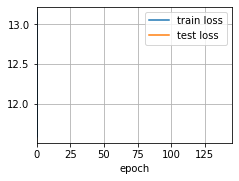

In [ ]:
def lr(epoch):
    if epoch < 10: return 0.001 * (epoch + 1)
    if epoch < 85: return 0.01
    if epoch < 115: return 0.001
    if epoch < 145: return 0.0001

train(net, train_iter, test_iter, 145, lr=lr, momentum=0.9, weight_decay=5e-4, accum_batch_num=4, save_path='./model', pretrained=True)

In [ ]:
model_weight_path = './model/resnet18-pretrained-epoch-145.pth'

resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2]) # remove avg pool and fc
net = yolo.Yolo(backbone, backbone_out_channels=512)

net.load_state_dict(torch.load(model_weight_path))

In [ ]:
test_one_batch(net, test_iter_raw, 'cuda')

In [ ]:
test_fps(net, test_iter_raw, 'cuda')

In [ ]:
test_and_draw_mAP(net, test_iter_raw, 'cuda')